In [10]:
# load libraries
from arch import arch_model
import pandas as pd
from scipy import stats
from scipy.ndimage.interpolation import shift
import numpy as np
from sklearn.svm import NuSVR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import math
import statistics
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import norm
import matplotlib.colors as mcolors
import seaborn as sns

In [11]:
## load data and prepare output vector (target 'y')
df = pd.read_excel("regression_data.xlsx")
returns = df['log_ret']*100
y2 = returns**2
sp_sigma = pd.Series(y2)
sp_sigma = sp_sigma.rolling(window = 5).mean()
index1 = [0]
s_sigma = np.array(sp_sigma[4:])
s_sigma = np.delete(s_sigma,index1)
target_y = s_sigma[253:]

In [12]:
## prepare input vector
garch = df['garch'][258:]
avgarch = df['avgarch'][258:]
gjrgarch = df['gjrgarch'][258:]
tgarch = df['tgarch'][258:]
ngarch = df['ngarch'][258:]
nagarch = df['nagarch'][258:]
aparch = df['aparch'][258:]
allgarch = df['allgarch'][258:]
egarch = df['egarch'][258:]
norm = df['norm'][258:]
snorm = df['snorm'][258:]
std = df['std'][258:]
sstd = df['sstd'][258:]
ast = df['ast'][258:]
ast1 = df['ast1'][258:]
ald = df['ald'][258:]
har = df['har'][258:]
lhar = df['lhar'][258:]
harj = df['harj'][258:]
harq = df['harq'][258:]
char = df['char'][258:]
charq = df['charq'][258:]
sv = df['sv'][258:]
svt = df['svt'][258:]
svl = df['svl'][258:]
svtl = df['svtl'][258:]
cgarchtotal = df['cgarchtotal'][258:]
midastotal = df['midastotal'][258:]
carr = df['carr'][258:]
ccarrtotal = df['ccarrtotal'][258:]

In [13]:
## features_X will be a transpose vector of input variables
## target_y will be the dependent variable
features_X = np.vstack( (garch,avgarch,gjrgarch,tgarch,ngarch,nagarch,aparch,allgarch,egarch,norm,snorm,std,
                        sstd,ast,ast1,ald,har,lhar,harj,harq,char,charq,sv,svt,svl,svtl,cgarchtotal,midastotal,carr,
                         ccarrtotal) ).T
## split data for training and testing  
X_train, X_test, y_train, y_test= train_test_split(features_X, target_y, test_size = 0.5, shuffle = False)

In [14]:
# normalize data
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
y_train = y_train.reshape(-1,1)
sc_y = MinMaxScaler()
y_train = sc_y.fit_transform(y_train)

In [15]:
# gridsearch different values of nu and pick the best for training the complete sample
# linear kernel
params = [
    {
        'nu': np.arange(0.05, 1.0, 0.05),
        'gamma': ['auto'],
        'kernel': ['poly'],
        'C':[10]
    }
]
svr = GridSearchCV(NuSVR(C = 10.0, kernel = 'poly'), param_grid = params, n_jobs = -1, cv = 8, scoring = 'r2')
model = svr.fit(X_train,y_train)

c:\users\public\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\public\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
#svr.best_estimator_
#model.best_score_
#svr.get_params()
#model.cv_results_
pd.concat([pd.DataFrame(model.cv_results_["params"]),pd.DataFrame(model.cv_results_["mean_test_score"],
                                                                        columns=["R2"])],axis=1)
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index=np.round(np.arange(0.05, 1.0, 0.05),2), columns='param_nu')

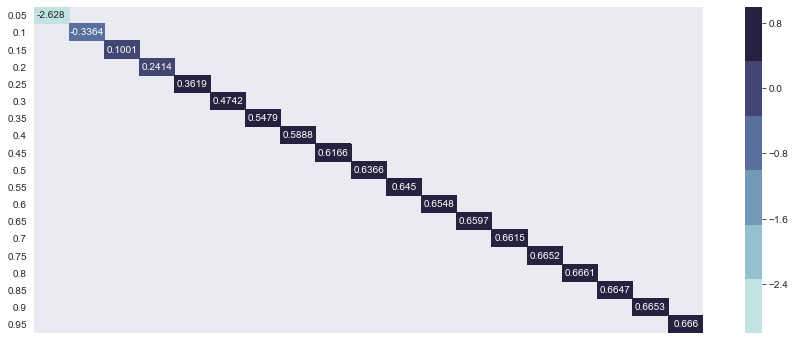

In [19]:
plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
cd = sns.color_palette("ch:start=.2,rot=-.3")

ax = sns.heatmap(pvt, annot=True, cmap=cd,vmin=-3, vmax=1, fmt='.4g', 
                 linecolor="black",xticklabels=False, yticklabels=True)
ax.set(xlabel=None)
plt.savefig('fig9a.pdf')  

In [20]:
params = [
    {
        'nu': [0.8],
        'gamma': ['auto'],
        'kernel': ['poly'],
        'C':[10]
    }
]
svr = GridSearchCV(NuSVR(C = 10.0, kernel = 'poly'), param_grid = params, n_jobs = -1, cv = 8, scoring = 'r2')
model = svr.fit(X_train,y_train)
train_pred = model.predict(X_train)
train_pred= train_pred.reshape(1,-1)
correlation_matrix = np. corrcoef(y2[258:1551], sc_y.inverse_transform(train_pred))
correlation_xy = correlation_matrix[0,1]
r_squared_train = correlation_xy**2
print("SVR Train R^2 Score: %.4f"
      % r_squared_train)

SVR Train R^2 Score: 0.1645


c:\users\public\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
test_pred = model.predict(X_test)
test_pred= test_pred.reshape(1,-1)
correlation_matrix = np. corrcoef(y2[1551:], sc_y.inverse_transform(test_pred))
correlation_xy = correlation_matrix[0,1]
r_squared_train = correlation_xy**2
print("SVR Test R^2 Score: %.4f"
      % r_squared_train)

SVR Test R^2 Score: 0.0037


In [22]:
## features_X will be a transpose vector of input variables
## target_y will be the dependent variable
target_y = df['rv_15'][258:]
features_X = np.vstack( (garch,avgarch,gjrgarch,tgarch,ngarch,nagarch,aparch,allgarch,egarch,norm,snorm,std,
                        sstd,ast,ast1,ald,har,lhar,harj,harq,char,charq,sv,svt,svl,svtl,cgarchtotal,midastotal,carr,
                         ccarrtotal) ).T
## split data for training and testing  
X_train, X_test, y_train, y_test= train_test_split(features_X, target_y, test_size = 0.5, shuffle = False)

In [23]:
# normalize data
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
y_train = y_train.values.reshape(-1,1)
sc_y = MinMaxScaler()
y_train = sc_y.fit_transform(y_train)

In [24]:
# gridsearch different values of nu and pick the best for training the complete sample
# linear kernel
params = [
    {
        'nu': np.arange(0.05, 1.0, 0.05),
        'gamma': ['auto'],
        'kernel': ['poly'],
        'C':[10]
    }
]
svr = GridSearchCV(NuSVR(C = 10.0, kernel = 'poly'), param_grid = params, n_jobs = -1, cv = 8, scoring = 'r2')
model = svr.fit(X_train,y_train)

c:\users\public\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\public\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
#svr.best_estimator_
#model.best_score_
#svr.get_params()
#model.cv_results_
pd.concat([pd.DataFrame(model.cv_results_["params"]),pd.DataFrame(model.cv_results_["mean_test_score"],
                                                                        columns=["R2"])],axis=1)
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index=np.round(np.arange(0.05, 1.0, 0.05),2), columns='param_nu')

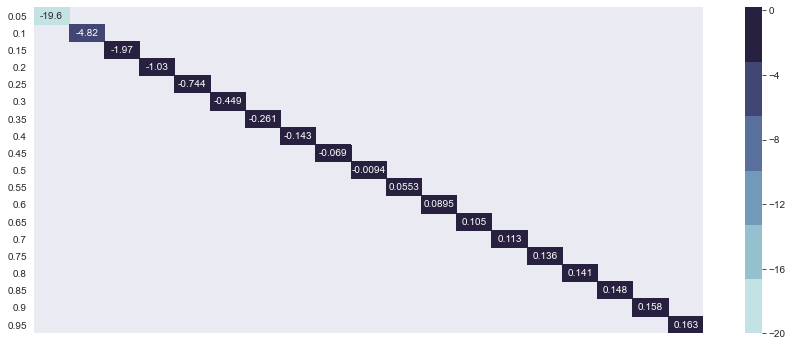

In [28]:
plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
cd = sns.color_palette("ch:start=.2,rot=-.3")
ax = sns.heatmap(pvt, annot=True, cmap=cd,vmin=-20, vmax=0.2, fmt='.3g', 
                 linecolor="black",xticklabels=False, yticklabels=True)
ax.set(xlabel=None)
plt.savefig('fig9b.pdf')

In [29]:
params = [
    {
        'nu': [0.95],
        'gamma': ['auto'],
        'kernel': ['poly'],
        'C':[10]
    }
]
svr = GridSearchCV(NuSVR(C = 10.0, kernel = 'poly'), param_grid = params, n_jobs = -1, cv = 8, scoring = 'r2')
model = svr.fit(X_train,y_train)
train_pred = model.predict(X_train)
train_pred= train_pred.reshape(1,-1)
correlation_matrix = np. corrcoef(y2[258:1551], sc_y.inverse_transform(train_pred))
correlation_xy = correlation_matrix[0,1]
r_squared_train = correlation_xy**2
print("SVR Train R^2 Score: %.4f"
      % r_squared_train)

SVR Train R^2 Score: 0.4480


c:\users\public\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
test_pred = model.predict(X_test)
test_pred= test_pred.reshape(1,-1)
correlation_matrix = np. corrcoef(y2[1551:], sc_y.inverse_transform(test_pred))
correlation_xy = correlation_matrix[0,1]
r_squared_train = correlation_xy**2
print("SVR Test R^2 Score: %.4f"
      % r_squared_train)

SVR Test R^2 Score: 0.0048


In [31]:
## features_X will be a transpose vector of input variables
## target_y will be the dependent variable
target_y = df['range_ret'][258:]
features_X = np.vstack( (garch,avgarch,gjrgarch,tgarch,ngarch,nagarch,aparch,allgarch,egarch,norm,snorm,std,
                        sstd,ast,ast1,ald,har,lhar,harj,harq,char,charq,sv,svt,svl,svtl,cgarchtotal,midastotal,carr,
                         ccarrtotal) ).T
## split data for training and testing  
X_train, X_test, y_train, y_test= train_test_split(features_X, target_y, test_size = 0.5, shuffle = False)

In [32]:
# normalize data
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
y_train = y_train.values.reshape(-1,1)
sc_y = MinMaxScaler()
y_train = sc_y.fit_transform(y_train)

In [33]:
# gridsearch different values of nu and pick the best for training the complete sample
# linear kernel
params = [
    {
        'nu': np.arange(0.05, 1.0, 0.05),
        'gamma': ['auto'],
        'kernel': ['poly'],
        'C':[10]
    }
]
svr = GridSearchCV(NuSVR(C = 10.0, kernel = 'poly'), param_grid = params, n_jobs = -1, cv = 8, scoring = 'r2')
model = svr.fit(X_train,y_train)

c:\users\public\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\public\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
#svr.best_estimator_
#model.best_score_
#svr.get_params()
#model.cv_results_
pd.concat([pd.DataFrame(model.cv_results_["params"]),pd.DataFrame(model.cv_results_["mean_test_score"],
                                                                        columns=["R2"])],axis=1)
pvt = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index=np.round(np.arange(0.05, 1.0, 0.05),2), columns='param_nu')

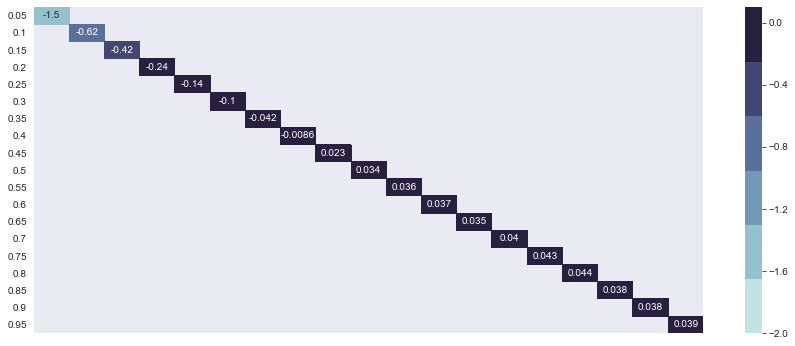

In [38]:
plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
cd = sns.color_palette("ch:start=.2,rot=-.3")
ax = sns.heatmap(pvt, annot=True, cmap=cd,vmin=-2, vmax=0.1, fmt='.2g', 
                 linecolor="black",xticklabels=False, yticklabels=True)
ax.set(xlabel=None)
plt.savefig('fig9c.pdf')

In [39]:
params = [
    {
        'nu': [0.8],
        'gamma': ['auto'],
        'kernel': ['poly'],
        'C':[10]
    }
]
svr = GridSearchCV(NuSVR(C = 10.0, kernel = 'poly'), param_grid = params, n_jobs = -1, cv = 8, scoring = 'r2')
model = svr.fit(X_train,y_train)
train_pred = model.predict(X_train)
train_pred= train_pred.reshape(1,-1)
correlation_matrix = np. corrcoef(y2[258:1551], sc_y.inverse_transform(train_pred))
correlation_xy = correlation_matrix[0,1]
r_squared_train = correlation_xy**2
print("SVR Train R^2 Score: %.4f"
      % r_squared_train)

SVR Train R^2 Score: 0.4042


c:\users\public\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
c:\users\public\anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
test_pred = model.predict(X_test)
test_pred= test_pred.reshape(1,-1)
correlation_matrix = np. corrcoef(y2[1551:], sc_y.inverse_transform(test_pred))
correlation_xy = correlation_matrix[0,1]
r_squared_train = correlation_xy**2
print("SVR Test R^2 Score: %.4f"
      % r_squared_train)

SVR Test R^2 Score: 0.0206
